# 1 Caso no isotrópico

Partiendo de la ecuacion inicial del calor pero en un medio no isotrópico (la conductividad termica varia punto a punto) y aplicando la regla de la cadena nos queda

$$\rho c_{p} \frac{\partial T}{\partial t} = \frac{\partial}{\partial x} \left( k \frac{\partial T}{\partial x} \right) + \frac{\partial}{\partial y} \left( k \frac{\partial T}{\partial y} \right) \quad 0 \leq x \leq L, \quad 0 \leq y \leq M, \quad t \leq 0$$

$$\rho c_{p} \frac{\partial T}{\partial t} = \frac{\partial k}{\partial x} \frac{\partial T}{\partial x} + k \frac{\partial^{2}T}{\partial x^{2}} + \frac{\partial k}{\partial y} \frac{\partial T}{\partial y} + k \frac{\partial^{2}T}{\partial y^{2}}$$

Discretizando la ecuacion anterior usando forward difference en la deribada respecto al tiempo y central difference (de primer y segundo orden segun corresponda) en las derivadas respecto al espacio, teniendo en cuenta el material del plano puede variar punto a punto ($k$, $\rho$ y $c_{p}$ son matrices ahora) y reordenando los terminos obtenidos podemos llegar a

$$T^{m+1}_{i, j} = T^{m}_{i, j} \left( 1 - 4\frac{1}{\rho c_{p}}\frac{\Delta t}{h^{2}} k^{m}_{i, j} \right) + \frac{1}{4\rho c_{p}} \frac{\Delta t}{h^{2}} T^{m}_{i+1, j} \left( 4k^{m}_{i, j} + k^{m}_{i+1, j} - k^{m}_{i-1,j} \right) + \frac{1}{4\rho c_{p}} \frac{\Delta t}{h^{2}} T^{m}_{i, j+1} \left( 4k^{m}_{i, j} + k^{m}_{i, j+1} - k^{m}_{i,j-1} \right) + \frac{1}{4\rho c_{p}} \frac{\Delta t}{h^{2}} T^{m}_{i-1, j} \left( 4k^{m}_{i, j} - k^{m}_{i+1, j} + k^{m}_{i-1,j} \right) + \frac{1}{4\rho c_{p}} \frac{\Delta t}{h^{2}} T^{m}_{i, j-1} \left( 4k^{m}_{i, j} - k^{m}_{i, j+1}  + k^{m}_{i,j-1} \right)$$

Dos observaciones interesantes sobre esta ultima ecuacion:
1. Si $k$ es el mismo para todo punto, esta ultima ecuacion queda igual a la obtenida en el notebook anterior.
2. La temperatura para un tiempo $t=m+1$ depende de del la constante termica del punto pero los vecinos contribuyen con un 1/4 de su conductividad termica.

Reemplazando $n = \frac{1}{4}\frac{1}{\rho c_{p}}\frac{\Delta t}{h^{2}}$ la forma discreta nos queda

$$T^{m+1}_{i, j} = T^{m}_{i, j} \left( 1 - 16nk^{m}_{i, j} \right) + nT^{m}_{i+1, j} \left( 4k^{m}_{i, j} + k^{m}_{i+1, j} - k^{m}_{i-1,j} \right) + nT^{m}_{i, j+1} \left( 4k^{m}_{i, j} + k^{m}_{i, j+1} - k^{m}_{i,j-1} \right) + nT^{m}_{i-1, j} \left( 4k^{m}_{i, j} - k^{m}_{i+1, j} + k^{m}_{i-1,j} \right) + nT^{m}_{i, j-1} \left( 4k^{m}_{i, j} - k^{m}_{i, j+1}  + k^{m}_{i,j-1} \right)$$

## 1.2 Estabilidad numerica

## 1.3 Dirichlet boundary condition

## 1.4 Neumann boundary condition

In [1]:
import yaml
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import HTML

In [2]:
class HeatEq:
    def __init__(self, config_path):
        with open(config_path) as f:
            self.config = yaml.load(f, Loader=yaml.CLoader)
        
        # Load kappa, density and heat capacity matrix
        self.K = np.load(self.config['kappa'])
        self.R = np.load(self.config['density'])
        self.Cp = np.load(self.config['heat_capacity'])
        
        # Delta de tiempo [s]
        k_min = self.K.max()
        r_min = self.R.max()
        cp_min = self.Cp.max()
        self.dt = (r_min*cp_min*self.config['h']**2)/(4*k_min)
        self.dt = 0.001
        # Grid points
        self.nx = int(self.config['L']/self.config['h'])
        self.ny = int(self.config['M']/self.config['h'])

        self.partials = []
        
    def solve(self):
        n = 0.25*self.dt/(self.R*self.Cp*self.config['h']**2)

        # Temperature matrix
        T = np.ones((self.nx, self.ny))

        # Initial temp
        T = self.config['temp_init'] * T
        T_new = T.copy()
                
        # Initial conditions
        T, T_new = self.__bounries(T, T_new, n)

        self.partials = []
        self.partials.append(T)

        total = int(self.config['time']/self.dt)
        step = int(self.config['img_at']*total/100)

        for i in range(total):
            if i % 100 == 0:
                print(f'\rSolving iteration {i}/{total} ({i*100/total:.2f}%)', end='')
            
            T_new[1:-1, 1:-1] = T[1:-1, 1:-1]*(1 - 16*n[1:-1, 1:-1]*self.K[1:-1, 1:-1]) \
                + n[1:-1, 1:-1]*T[1:-1, 2:]* (4*self.K[1:-1, 1:-1] + self.K[1:-1, 2:] - self.K[1:-1, :-2]) \
                + n[1:-1, 1:-1]*T[2:, 1:-1]* (4*self.K[1:-1, 1:-1] + self.K[2:, 1:-1] - self.K[:-2, 1:-1]) \
                + n[1:-1, 1:-1]*T[1:-1, :-2]*(4*self.K[1:-1, 1:-1] - self.K[1:-1, 2:] + self.K[1:-1, :-2]) \
                + n[1:-1, 1:-1]*T[:-2, 1:-1]*(4*self.K[1:-1, 1:-1] - self.K[2:, 1:-1] + self.K[:-2, 1:-1])

            # Boundary conditions
            T, T_new = self.__bounries(T, T_new, n)

            if i % step == 0:
                self.partials.append(T.copy())
            
        self.partials.append(T.copy())

    
    def plot(self, colors=['#00008f', '#009fff', '#8fff6f', '#ff6f00', '#7f0000'], n_bins=100):
        fig_index = 0
        temp_min = min([p.min() for p in self.partials])
        temp_max = max([p.max() for p in self.partials])

        # Create the colormap
        cm = LinearSegmentedColormap.from_list('custom_bar', colors, N=n_bins)

        fig, ax = plt.subplots(figsize=(8, 6))
        im = plt.imshow(self.partials[0], vmin=temp_min, vmax=temp_max, interpolation='nearest', cmap=cm)
        
        # Set axis and ref
        x_labels = [f'{i:.3f}' for i in np.linspace(0, self.config['L'], num=10)]
        y_labels = [f'{i:.3f}' for i in np.linspace(0, self.config['M'], num=10)]
        plt.xticks(np.linspace(0, self.nx, num=10), x_labels, rotation=45)
        plt.yticks(np.linspace(0, self.ny, num=10), y_labels)
        plt.colorbar()

        def updatefig(frame):
            total = int(self.config['time']/self.dt)
            step = int(self.config['img_at']*total/100)
            
            im.set_array(self.partials[frame + 1])
            ax.set_title(f'Time: {self.dt * step * frame:.2g} seg')
            return im,

        anim = animation.FuncAnimation(fig, updatefig, frames=len(self.partials) - 1, blit=True)
        return HTML(anim.to_jshtml())


    def __bounries(self, T, T_new, n):
        # Boundary conditions
        if 'left' in self.config['boundary'] and self.config['boundary']['left']['type'] == 'dirichlet':
            T_new[:, 0] = self.config['boundary']['left']['value']
        elif 'left' in self.config['boundary'] and self.config['boundary']['left']['type'] == 'neumann':
            T_new[1:-1, 0] = T[1:-1, 0]*(1 - 16*n[1:-1, 0]*self.K[1:-1, 0]) \
                + 2*n[1:-1, 0]*T[1:-1, 1]* (4*self.K[1:-1, 0]) \
                + n[1:-1, 0]*T[2:, 0]* (4*self.K[1:-1, 0]) \
                + n[1:-1, 0]*T[:-2, 0]*(4*self.K[1:-1, 0])

        if 'top' in self.config['boundary'] and self.config['boundary']['top']['type'] == 'dirichlet':
            T_new[0, :] = self.config['boundary']['top']['value']
        elif 'top' in self.config['boundary'] and self.config['boundary']['top']['type'] == 'neumann':
            T_new[0, 1:-1] = T[0, 1:-1]*(1 - 16*n[0, 1:-1]*self.K[0, 1:-1]) \
                + n[0, 1:-1]*T[0, 2:]* (4*self.K[0, 1:-1]) \
                + 2*n[0, 1:-1]*T[1, 1:-1]* (4*self.K[0, 1:-1]) \
                + n[0, 1:-1]*T[0, :-2]*(4*self.K[0, 1:-1])

        if 'right' in self.config['boundary'] and self.config['boundary']['right']['type'] == 'dirichlet':
            T_new[:, -1] = self.config['boundary']['right']['value']
        elif 'right' in self.config['boundary'] and self.config['boundary']['right']['type'] == 'neumann':
            T_new[1:-1, -1] = T[1:-1, -1]*(1 - 16*n[1:-1, -1]*self.K[1:-1, -1]) \
                + n[1:-1, -1]*T[2:, -1]* (4*self.K[1:-1, -1]) \
                + 2*n[1:-1, -1]*T[1:-1, -2]*(4*self.K[1:-1, -2]) \
                + n[1:-1, -1]*T[:-2, -1]*(4*self.K[1:-1, -1])

        if 'bottom' in self.config['boundary'] and self.config['boundary']['bottom']['type'] == 'dirichlet':
            T_new[-1, :] = self.config['boundary']['bottom']['value']
        elif 'bottom' in self.config['boundary'] and self.config['boundary']['bottom']['type'] == 'neumann':
            T_new[-1, 1:-1] = T[-1, 1:-1]*(1 - 16*n[-1, 1:-1]*self.K[-1, 1:-1]) \
                + n[-1, 1:-1]*T[-1, 2:]* (4*self.K[-1, 1:-1]) \
                + n[-1, 1:-1]*T[-1, :-2]*(4*self.K[-1, 1:-1]) \
                + 2*n[-1, 1:-1]*T[-2, 1:-1]*(4*self.K[-2, 1:-1])

        T = T_new.copy()

        return T, T_new

In [55]:
# Plancha uniforma de aluminio
with open('./input/config-no-iso.yaml') as f:
    config = yaml.load(f, Loader=yaml.CLoader)
    
nx = int(config['L']/config['h'])
ny = int(config['M']/config['h'])

kappa = np.ones((ny, nx))
kappa = 237 * kappa
np.save('input/kappa-no-iso', kappa)

density = np.ones((ny, nx))
density = 2705 * density
np.save('input/density-no-iso', density)

heat_capacity = np.ones((ny, nx))
heat_capacity = 900 * heat_capacity
np.save('input/heat-capacity-no-iso', heat_capacity)

Solving iteration 119900/120000 (99.92%)

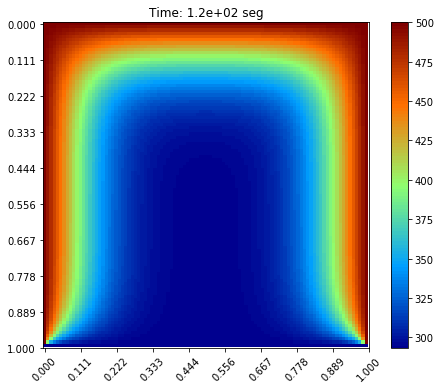

In [56]:
# Una fuente de calor en todos los bordes de 500K salvo abajo que es de 293K
# Sobre una plancha de aluminio
heat = HeatEq('./input/config-no-iso.yaml')
heat.solve()
heat.plot()

In [3]:
# Plancha de aluminio con un cuadrada de cobre en el centro
with open('./input/config-no-iso-sqr.yaml') as f:
    config = yaml.load(f, Loader=yaml.CLoader)
    
nx = int(config['L']/config['h'])
ny = int(config['M']/config['h'])

# Al data
kappa = np.ones((ny, nx))
kappa = 237 * kappa

density = np.ones((ny, nx))
density = 2705 * density

heat_capacity = np.ones((ny, nx))
heat_capacity = 900 * heat_capacity

# Gold data
for i, j in [[i, j] for i in range(int(nx/2), nx) for j in range(ny)]:
    kappa[j, i] = 314
    density[j, i] = 19300
    heat_capacity[j, i] = 125

np.save('input/kappa-no-iso-sqr', kappa)
np.save('input/density-no-iso-sqr', density)
np.save('input/heat-capacity-no-iso-sqr', heat_capacity)

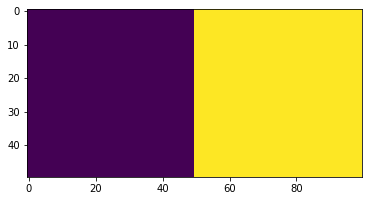

In [4]:
plt.imshow(kappa)

In [5]:
# Una fuente de calor en todos los bordes de 500K salvo abajo que es de 293K
# Sobre una plancha de aluminio con un cuadrado de oro
heat = HeatEq('./input/config-no-iso-sqr.yaml')
heat.solve()
heat.plot()

Solving iteration 0/200000 (0.00%)

ValueError: operands could not be broadcast together with shapes (98,48) (48,98) 

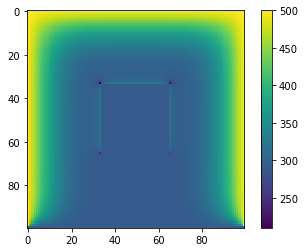

In [75]:
plt.imshow(heat.partials[7])
plt.colorbar()

In [10]:
# Plancha diagonal inf al, diagonal sup cobre
with open('./input/config-no-iso-dia.yaml') as f:
    config = yaml.load(f, Loader=yaml.CLoader)
    
nx = int(config['L']/config['h'])
ny = int(config['M']/config['h'])

# Al data
kappa = np.ones((nx, ny))
kappa = 237 * kappa

density = np.ones((nx, ny))
density = 2705 * density

heat_capacity = np.ones((nx, ny))
heat_capacity = 900 * heat_capacity

# Copper data
for i, j in [[i, j] for i in range(0, nx) for j in range(0, ny)]:
    if i >= j:
        kappa[i, j] = 385
        density[i, j] = 8944
        heat_capacity[i, j] = 376

np.save('input/kappa-no-iso-dia', kappa)
np.save('input/density-no-iso-dia', density)
np.save('input/heat-capacity-no-iso-dia', heat_capacity)

Solving iteration 119900/120000 (99.92%)

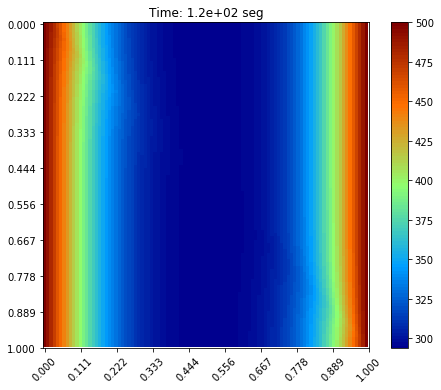

In [18]:
# Una fuente de calor arriba de 600K
heat = HeatEq('./input/config-no-iso-dia.yaml')
heat.solve()
heat.plot()